### Import

In [11]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [4]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../rdkit_data/rdkit_train_corr_0.4.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,BCUT2D_LOGPLOW,Chi0,Chi0n,Chi0v,Chi1,...,SlogP_VSA5,HeavyAtomCount,NOCount,NumAromaticCarbocycles,NumAromaticHeterocycles,NumHeteroatoms,NumRotatableBonds,fr_NH0,fr_benzene,fr_pyridine
0,10.59,535.624,501.352,535.270716,206,-2.500926,27.310826,22.307719,22.307719,18.685692,...,59.389368,39,10,1,2,11,7,6,1,0
1,10.11,537.596,505.340,537.249981,206,-2.563125,27.310826,22.008861,22.008861,18.685692,...,40.126903,39,11,1,2,12,7,6,1,0
2,10.09,545.566,515.326,545.236222,208,-2.476253,27.896612,21.649435,21.649435,18.507059,...,40.126903,39,10,1,2,13,8,6,1,0
3,10.00,571.604,539.348,571.251873,218,-2.567951,29.103719,22.856542,22.856542,19.392799,...,52.968546,41,10,1,2,13,7,6,1,0
4,10.00,473.537,446.321,473.217538,180,-2.455375,24.156125,19.769469,19.769469,16.970295,...,54.924759,35,10,1,3,10,4,6,1,0


In [5]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [6]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])

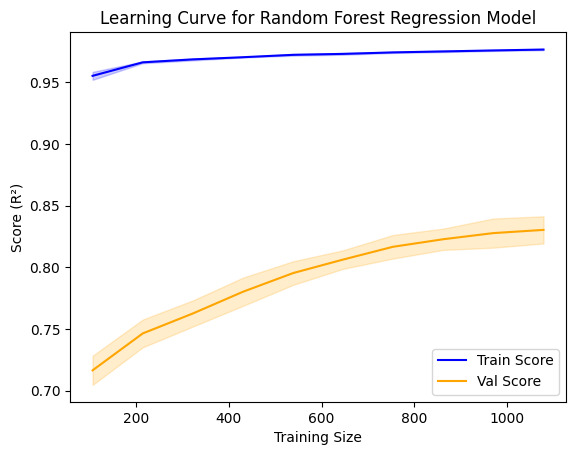

In [7]:
train_sizes, train_scores, val_scores = learning_curve(model, train_x, train_x, cv=5, 
                                                         n_jobs=-1, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10))

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 시각화
plt.plot(train_sizes, train_mean, label='Train Score', color='blue')
plt.plot(train_sizes, val_mean, label='Val Score', color='orange')

# 신뢰구간 표시
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.title('Learning Curve for Random Forest Regression Model')
plt.xlabel('Training Size')
plt.ylabel('Score (R²)')
plt.legend()
plt.show()

In [8]:
model.fit(train_x, train_y)

c:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [14]:
# pIC50에서 IC50을 계산하는 함수
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Normalized RMSE를 계산하는 함수
def calculate_normalized_rmse(true_pIC50, predicted_pIC50):
    """
    Normalized RMSE 계산.
    Normalized RMSE = RMSE / (max(true_IC50) - min(true_IC50))
    """
    # RMSE 계산
    mse = mean_squared_error(pIC50_to_IC50(true_pIC50), pIC50_to_IC50(predicted_pIC50))
    rmse = np.sqrt(mse)
    # Normalized RMSE 계산
    norm_rmse = rmse / (np.max(pIC50_to_IC50(true_pIC50)) - np.min(pIC50_to_IC50(predicted_pIC50)))
    return norm_rmse

# pIC50에서 Correct Ratio를 계산하는 함수
def calculate_correct_ratio(true_pIC50, predicted_pIC50):
    """
    Correct Ratio 계산.
    Correct Ratio = 1/N * Σ I(Absolute Error <= 0.5)
    """
    # 절대 오차 계산
    abs_errors = np.abs(predicted_pIC50 - true_pIC50)
    # 절대 오차가 0.5 이하인 경우의 수 계산
    correct_count = np.sum(abs_errors <= 0.5)
    # Correct Ratio 계산
    correct_ratio = correct_count / len(true_pIC50)
    return correct_ratio

# 최종 Score를 계산하는 함수
def calculate_score(true_pIC50, predicted_pIC50):
    """
    주어진 실제 IC50 값과 예측 IC50 값을 기반으로 Score 계산.
    Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    """
    # Normalized RMSE 계산 (A 값)
    norm_rmse = calculate_normalized_rmse(true_pIC50, predicted_pIC50)

    # Correct Ratio 계산 (B 값)
    correct_ratio = calculate_correct_ratio(true_pIC50, predicted_pIC50)

    # 최종 Score 계산
    # Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    score = 0.5 * (1 - min(norm_rmse, 1)) + 0.5 * correct_ratio
    
    return score

In [9]:
val_y_pred = model.predict(val_x)
val_y = np.array(val_y)
val_y = val_y.ravel()

In [12]:
r2 = r2_score(val_y, val_y_pred)
print(r2)

0.5587209012938765


In [15]:
norm_rmse = calculate_normalized_rmse(val_y, val_y_pred)
correct_ratio = calculate_correct_ratio(val_y, val_y_pred)
score = calculate_score(val_y, val_y_pred)
print(f"norm_rmse: {norm_rmse:.4f}")
print(f"correct_ratio: {correct_ratio:.4f}")
print(f"Calculated Score: {score:.4f}")

norm_rmse: 0.0794
correct_ratio: 0.6228
Calculated Score: 0.7717


In [8]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
top10 = ser.sort_values(ascending=False)[:10]
print(top10)

[0.01058427 0.02225655 0.01023997 0.00487907 0.12700877 0.0393087
 0.02106005 0.01998448 0.02311209 0.07762096 0.03970193 0.04303619
 0.01620708 0.03749311 0.07421903 0.13368721 0.00278328 0.01483214
 0.00778427 0.16844039 0.01494866 0.02326765 0.03571432 0.00711434
 0.02471548] 

NumAromaticHeterocycles    0.168440
SlogP_VSA5                 0.133687
BCUT2D_LOGPLOW             0.127009
Chi2n                      0.077621
SMR_VSA5                   0.074219
Kappa3                     0.043036
Kappa1                     0.039702
Chi0                       0.039309
SMR_VSA3                   0.037493
fr_NH0                     0.035714
dtype: float64


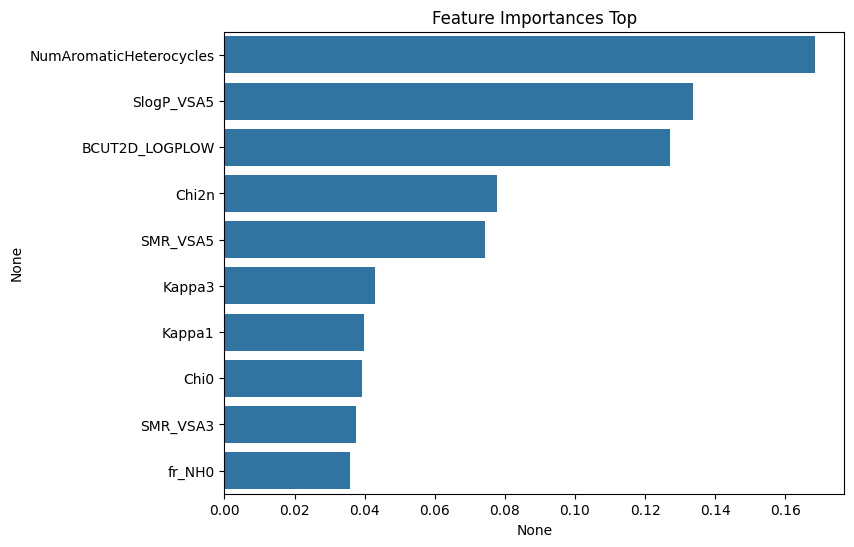

In [9]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top10, y=top10.index)
plt.show()

### Inference

In [10]:
test = pd.read_csv('./rdkit_test_corr_0.4.csv')

test_y_pred = model.predict(test)

### Submission

In [12]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,25.852348
1,TEST_001,17.510559
2,TEST_002,137.784384
3,TEST_003,21.062019
4,TEST_004,56.606547


In [13]:
submit.to_csv('./corr_0.4_submit.csv', index=False)